In [48]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics

import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

для начала обработаем наш датасет

In [49]:
url = "https://raw.githubusercontent.com/paveladim/csvcorr/master/traindatacredcard.csv"
data_raw = pd.read_csv(url)
url = "https://raw.githubusercontent.com/paveladim/csvcorr/master/testdatacredcard.csv"
data_raw1 = pd.read_csv(url)

# заполним столбец Is_Lead в тестовой выборке значением моды из обучающей выборки
_mode = data_raw['Is_Lead'].mode()
additional_column = np.zeros(len(data_raw1.index))
for i in range(len(additional_column)): additional_column[i] = _mode
add_column = pd.DataFrame({'Is_Lead' : additional_column})
data_raw1 = data_raw1.drop(['Is_Lead'], axis = 1)
data_raw1 = pd.concat((data_raw1, add_column), axis=1)

data_raw.append(data_raw1)

data_raw['ID'] = data_raw['ID'].astype('category')
data_raw['Gender'] = data_raw['Gender'].astype('category')
data_raw['Region_Code'] = data_raw['Region_Code'].astype('category')
data_raw['Occupation'] = data_raw['Occupation'].astype('category')
data_raw['Channel_Code'] = data_raw['Channel_Code'].astype('category')
data_raw['Credit_Product'] = data_raw['Credit_Product'].astype('category')
data_raw['Is_Active'] = data_raw['Is_Active'].astype('category')

rows_to_drop = data_raw[
    (data_raw['Avg_Account_Balance'] < data_raw['Avg_Account_Balance'].quantile(0.005)) 
    | (data_raw['Avg_Account_Balance'] > data_raw['Avg_Account_Balance'].quantile(0.900))].index

data = data_raw.drop(rows_to_drop)
data['Credit_Product'].fillna(data['Credit_Product'].mode().iloc[0], inplace=True)

data['Gender'] = pd.factorize(data['Gender'])[0]
data['Credit_Product'] = pd.factorize(data['Credit_Product'])[0]
data['Is_Active'] = pd.factorize(data['Is_Active'])[0]

Occupation_dummies = pd.get_dummies(data['Occupation'])
Channel_Code_dummies = pd.get_dummies(data['Channel_Code'])
Region_Code_dummies = pd.get_dummies(data['Region_Code'])

data = pd.concat((data, Occupation_dummies), axis=1)
data = data.drop(['Occupation'], axis=1)

data = pd.concat((data, Channel_Code_dummies), axis=1)
data = data.drop(['Channel_Code'], axis=1)

data = pd.concat((data, Region_Code_dummies), axis=1)
data = data.drop(['Region_Code'], axis=1)

# уберём ID, поскольку не нужно
data = data.drop(['ID'], axis = 1)
data_stand = (data - data.mean(axis = 0)) / data.std(axis = 0)

Разобьём на обучающую и тестовую выборки

In [50]:
X = data_stand.drop(['Is_Lead'], axis = 1)
y = data['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 66)

Начнём обучение

In [51]:
model = MLPClassifier(
    hidden_layer_sizes = (50, 30),
    solver = 'sgd',
    activation = 'logistic',
    random_state = 66
)
model.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 30),
              random_state=66, solver='sgd')

In [52]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [53]:
np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred)

(0.2233741353073486, 0.22063985740528547)

Подберём гиперпараметры

In [54]:
alpha_arr = np.logspace(-4, 5, 10)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(
                hidden_layer_sizes = (50, 30),
                solver = 'sgd',
                activation = 'logistic',
                random_state = 66,
                alpha = alpha
                )
    
    mlp_model.fit(X_train, y_train)
    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

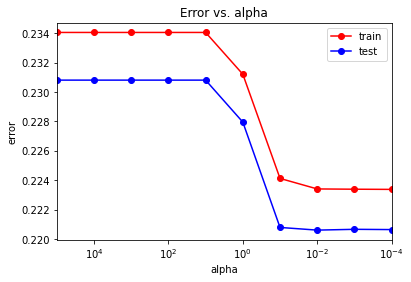

In [55]:
plt.semilogx(alpha_arr, train_err, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'b-o', label = 'test')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

Минимальное значение ошибки

In [56]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.2233741353073486 0.22060348120259726


Оптимальный параметр $\alpha$ равен

In [57]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.01]


In [58]:
alpha_opt = alpha_opt[0]

Классификатор при найденном $\alpha$

In [59]:
mlp_model = MLPClassifier(
                hidden_layer_sizes = (100,),
                solver = 'sgd',
                activation = 'logistic',
                random_state = 66,
                alpha = alpha
                )
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.23405055079633572
0.23080700605663776


Подберём количество нейронов

In [60]:
neuron_count_array = numpy.linspace(1, 800, 24).astype(int)
test_error = []
train_error = []
for neuron_count in neuron_count_array:
    model = MLPClassifier(
        hidden_layer_sizes = (neuron_count,),
        solver = 'sgd',
        activation = 'logistic',
        max_iter = 1000,
        random_state = 66,
        alpha = alpha_opt
    )
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    test_error.append(numpy.mean(y_test != y_test_pred))
    train_error.append(numpy.mean(y_train != y_train_pred))

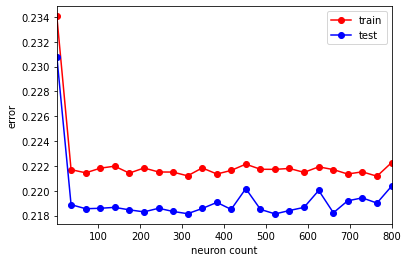

In [61]:
plt.plot(neuron_count_array, train_error, 'r-o', label='train')
plt.plot(neuron_count_array, test_error, 'b-o', label='test')
plt.xlim([numpy.min(neuron_count_array), numpy.max(neuron_count_array)])
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()
pass

In [62]:
min_test_error = np.min(test_error)
neuron_count_optimal = neuron_count_array[test_error == min_test_error][0]
print('Optimal neuron count: {}'.format(neuron_count_optimal))

Optimal neuron count: 522


Получили точность на тренировочной и тестовой выборе примерно 77%. Переобучения не наблюдается, но наблюдается недообучение (на тренировочной выборке большая ошибка). С помощью KNN результаты были получены немного лучше, чем здесь. Были найдены оптимальные значения $\alpha = 0.01$ и количества нейронов равное 522.